# 필요한 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore') #경고 무시

# 시계열 데이터 준비

[Yahoo Finance](https://finance.yahoo.com/)

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

## 삼성전자

In [2]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Ex_11/data/005930.KS.csv'  # 삼성전자 10년치
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 하루의 장이 마감하였을 때의 가격 : 종가

ts.head()

Date
2012-02-17    23520.0
2012-02-20    23500.0
2012-02-21    23600.0
2012-02-22    23940.0
2012-02-23    23200.0
Name: Close, dtype: float64

# 각종 전처리 수행

- 결측치 처리
- 로그 변환

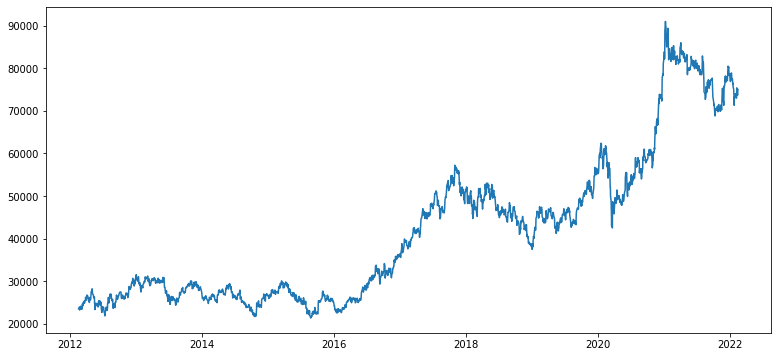

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts);

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

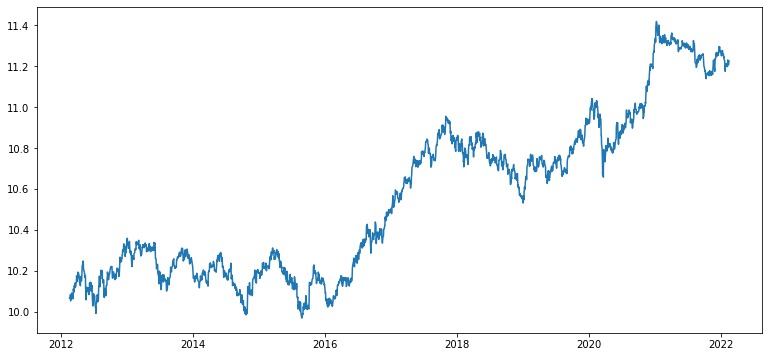

In [5]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log);

# 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [6]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

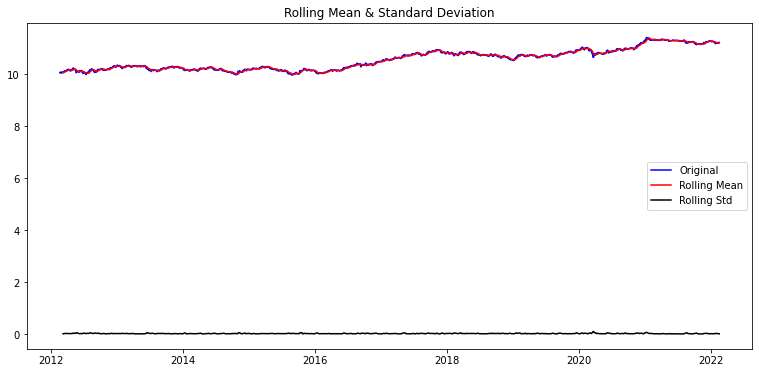

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [8]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.628469
p-value                           0.864419
#Lags Used                        3.000000
Number of Observations Used    2456.000000
Critical Value (1%)              -3.433015
Critical Value (5%)              -2.862718
Critical Value (10%)             -2.567397
dtype: float64


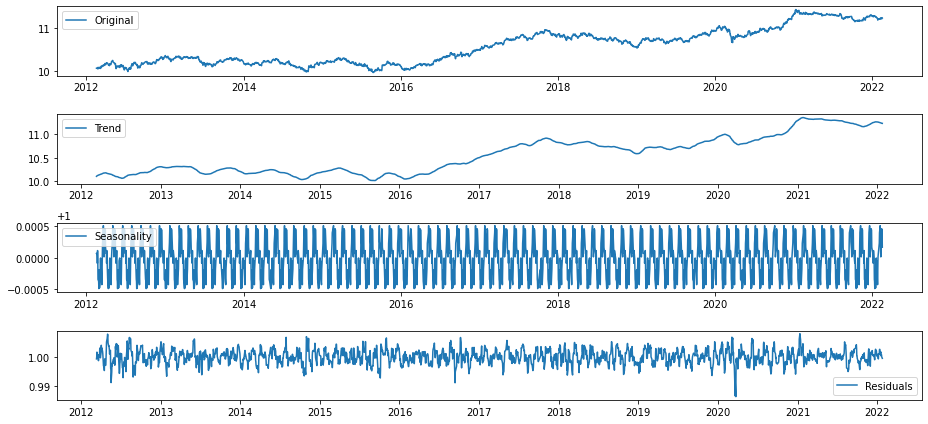

In [10]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

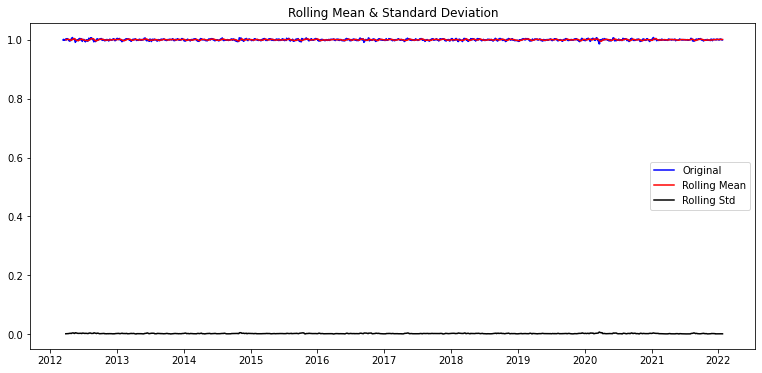

In [11]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.477325e+01
p-value                        2.305012e-27
#Lags Used                     2.300000e+01
Number of Observations Used    2.406000e+03
Critical Value (1%)           -3.433071e+00
Critical Value (5%)           -2.862742e+00
Critical Value (10%)          -2.567410e+00
dtype: float64


# 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

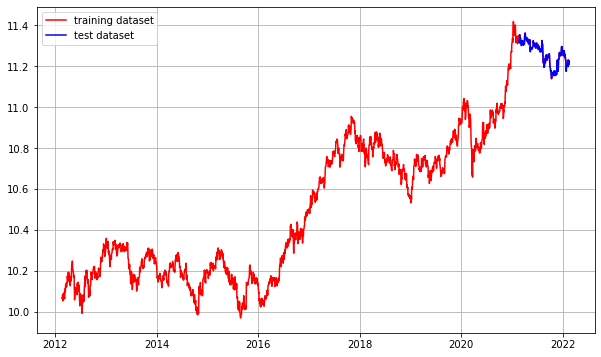

In [13]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_ss_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

# 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

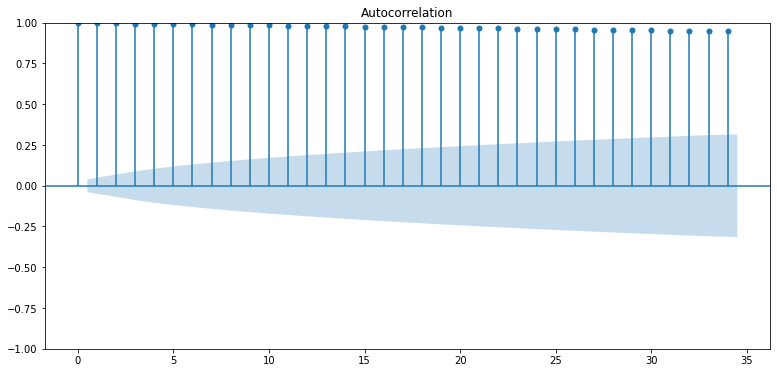

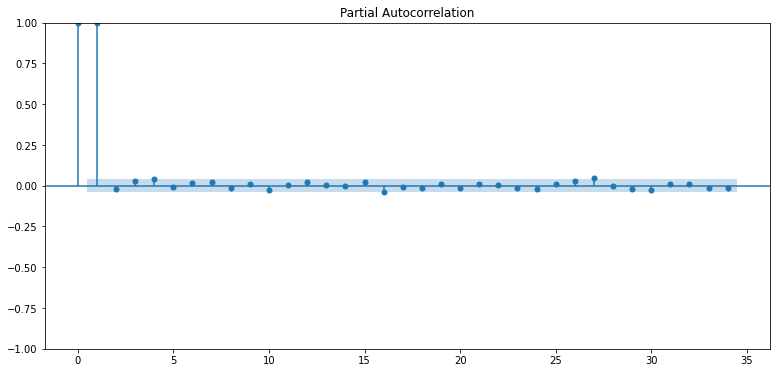

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -30.531158
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    2456.000000
Critical Value (1%)              -3.433015
Critical Value (5%)              -2.862718
Critical Value (10%)             -2.567397
dtype: float64


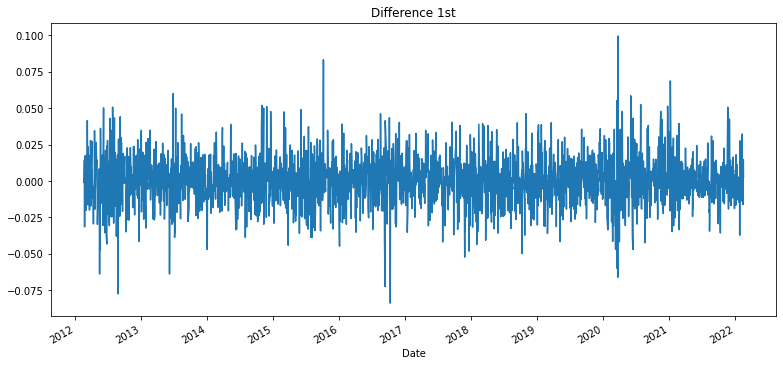

In [15]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.621541e+01
p-value                        3.947181e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.430000e+03
Critical Value (1%)           -3.433044e+00
Critical Value (5%)           -2.862730e+00
Critical Value (10%)          -2.567404e+00
dtype: float64


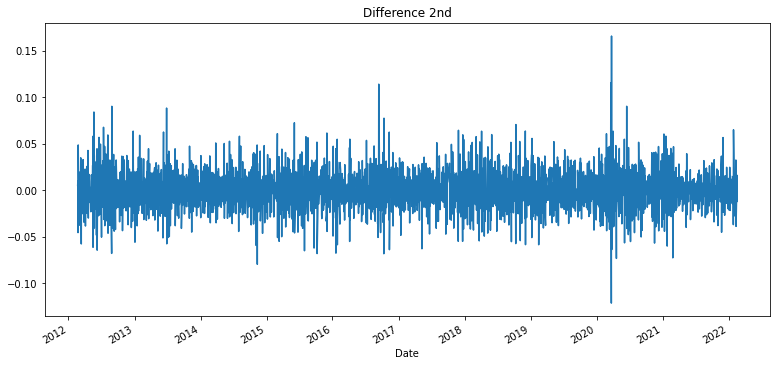

In [16]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [17]:
!pip install pmdarima

In [18]:
# 적절한 모수를 찾아주는 라이브러리
from pmdarima import auto_arima
stepwise_fit = auto_arima(ts_log, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13189.756, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13184.068, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13183.804, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13183.893, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13184.075, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13187.976, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13181.893, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-13187.179, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13188.498, Time=1.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13180.163, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-13190.028, Time=0.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-13189.505, Time=1.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-13188.196, Time=2.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13183.707, Time=0.64 sec
 ARIM

In [19]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 3))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2214
Model:                 ARIMA(1, 1, 3)   Log Likelihood                5884.794
Date:                Thu, 17 Feb 2022   AIC                         -11759.587
Time:                        08:48:15   BIC                         -11731.077
Sample:                             0   HQIC                        -11749.172
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4950      0.248      1.993      0.046       0.008       0.982
ma.L1         -0.4680      0.248     -1.890      0.059      -0.953       0.017
ma.L2         -0.0418      0.020     -2.140      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


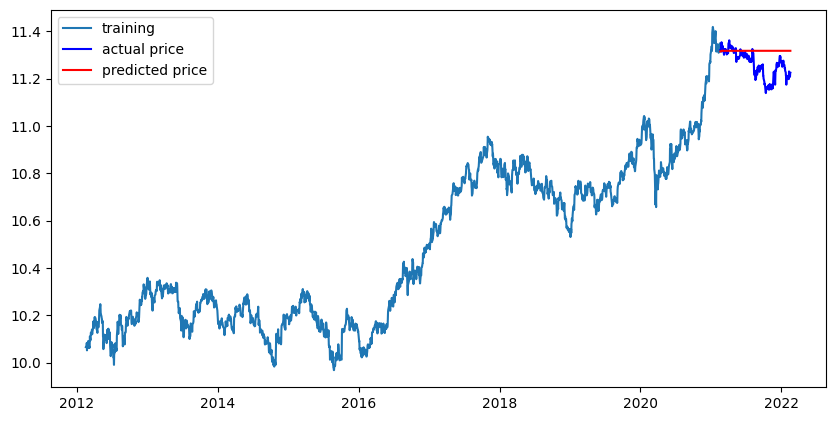

In [20]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  36948198.87158359
MAE:  4695.480400200561
RMSE:  6078.503012385829
MAPE: 6.32%


## 카카오

In [22]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Ex_11/data/035720.KS.csv'  # 카카오 10년치
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 하루의 장이 마감하였을 때의 가격 : 종가

ts.head()

Date
2012-02-17    22640.0
2012-02-20    22180.0
2012-02-21    22680.0
2012-02-22    22900.0
2012-02-23    23080.0
Name: Close, dtype: float64

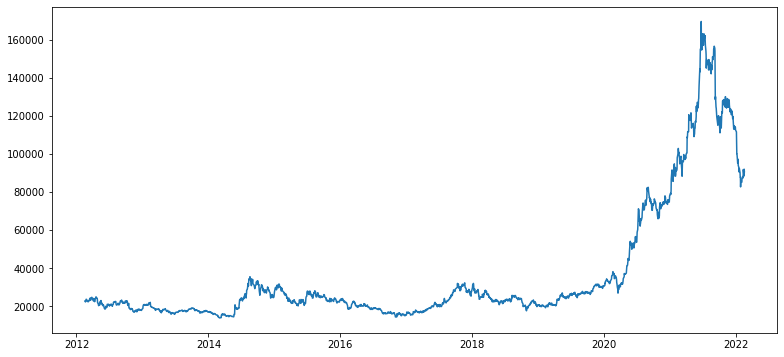

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts);

In [24]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

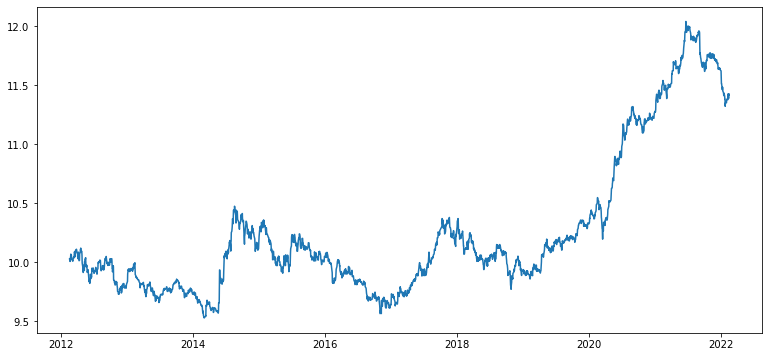

In [25]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log);

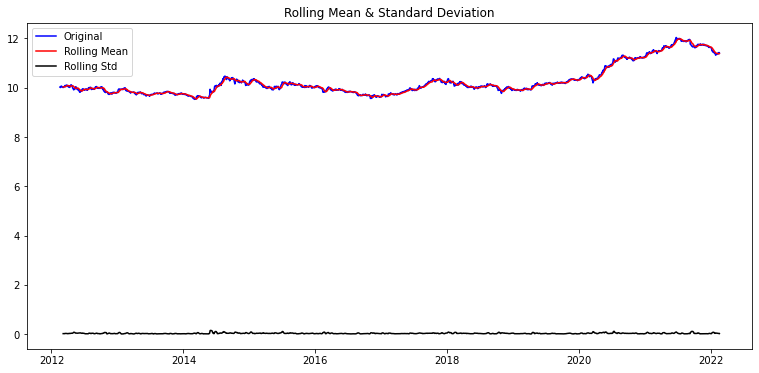

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [27]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.149365
p-value                           0.944294
#Lags Used                        7.000000
Number of Observations Used    2452.000000
Critical Value (1%)              -3.433020
Critical Value (5%)              -2.862719
Critical Value (10%)             -2.567398
dtype: float64


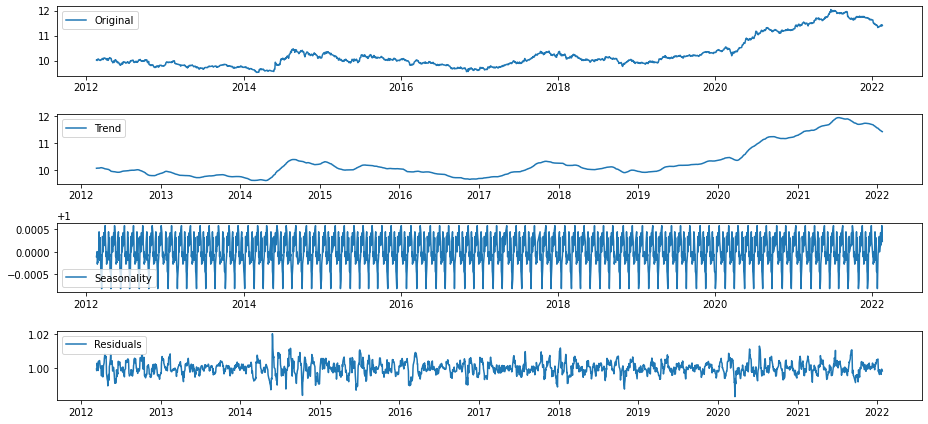

In [28]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

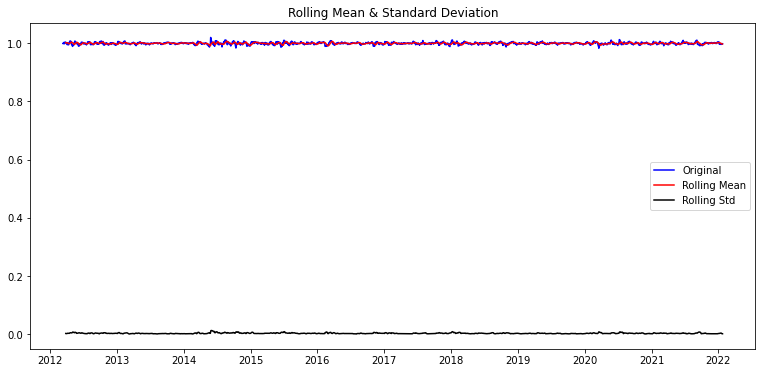

In [29]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [30]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.490716e+01
p-value                        1.476974e-27
#Lags Used                     1.900000e+01
Number of Observations Used    2.410000e+03
Critical Value (1%)           -3.433066e+00
Critical Value (5%)           -2.862740e+00
Critical Value (10%)          -2.567409e+00
dtype: float64


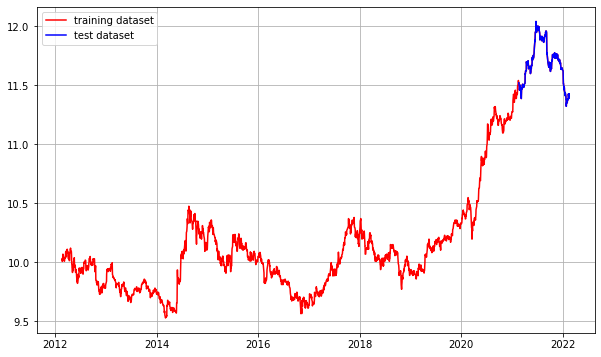

In [31]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

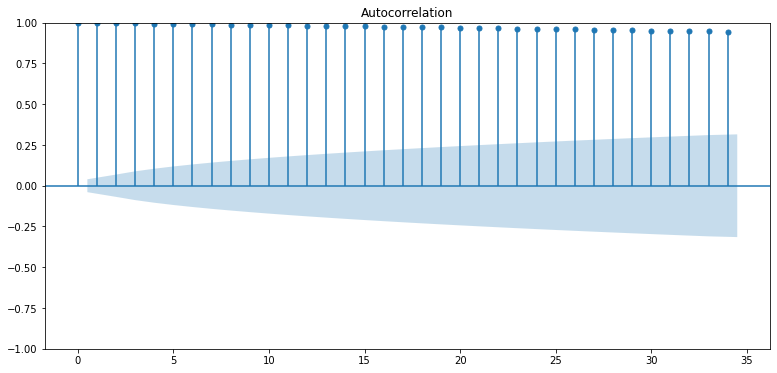

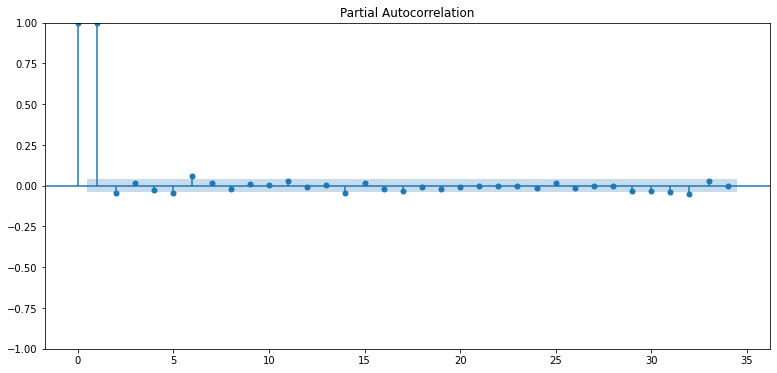

In [32]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.856521e+01
p-value                        2.085357e-30
#Lags Used                     6.000000e+00
Number of Observations Used    2.452000e+03
Critical Value (1%)           -3.433020e+00
Critical Value (5%)           -2.862719e+00
Critical Value (10%)          -2.567398e+00
dtype: float64


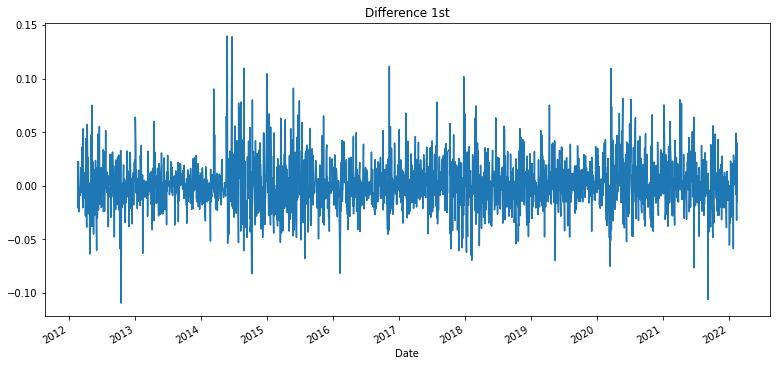

In [33]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.557390e+01
p-value                        1.970946e-28
#Lags Used                     2.700000e+01
Number of Observations Used    2.430000e+03
Critical Value (1%)           -3.433044e+00
Critical Value (5%)           -2.862730e+00
Critical Value (10%)          -2.567404e+00
dtype: float64


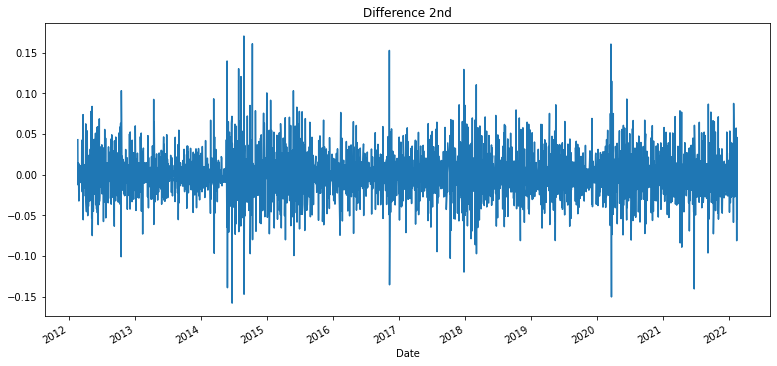

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [35]:
# 적절한 모수를 찾아주는 라이브러리
from pmdarima import auto_arima
stepwise_fit = auto_arima(ts_log, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11530.187, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11531.002, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11534.710, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11534.571, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11531.547, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11533.097, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11534.004, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11531.058, Time=1.64 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-11535.393, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11533.813, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11534.796, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11535.245, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-11532.875, Time=0.63 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.731 seco

In [36]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2214
Model:                 ARIMA(1, 1, 0)   Log Likelihood                5197.725
Date:                Thu, 17 Feb 2022   AIC                         -10391.450
Time:                        08:48:23   BIC                         -10380.046
Sample:                             0   HQIC                        -10387.284
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0481      0.015      3.173      0.002       0.018       0.078
sigma2         0.0005   9.68e-06     55.136      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


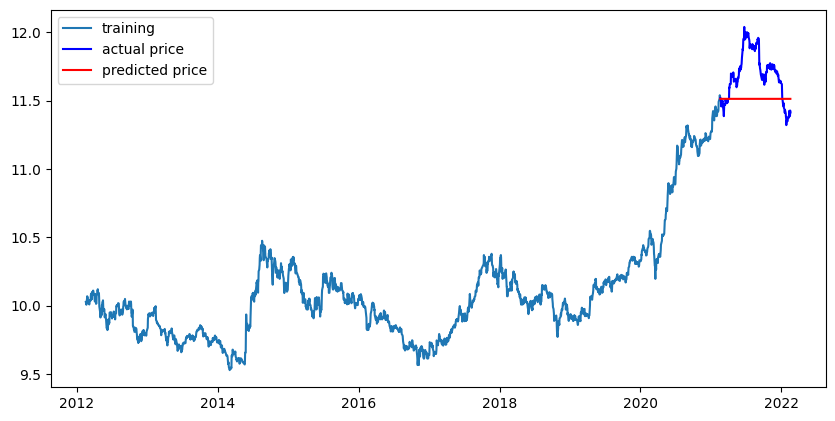

In [37]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  926665434.4478781
MAE:  24712.319566817576
RMSE:  30441.179912215594
MAPE: 18.54%


# 네이버

In [39]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Ex_11/data/035420.KS.csv'  # 네이버 10년치
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 하루의 장이 마감하였을 때의 가격 : 종가

ts.head()

Date
2012-02-17    53809.171875
2012-02-20    53073.738281
2012-02-21    54667.179688
2012-02-22    56628.332031
2012-02-23    58834.628906
Name: Close, dtype: float64

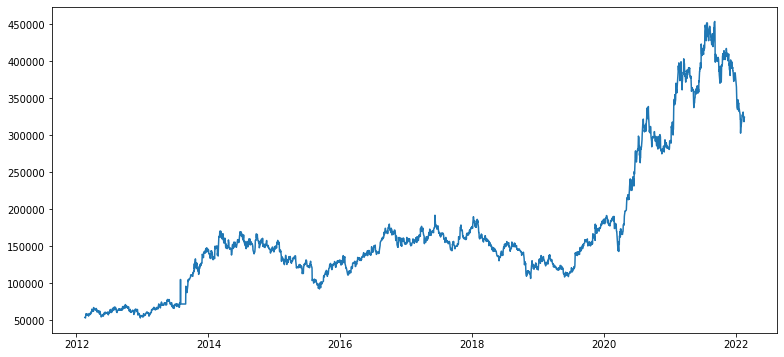

In [40]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts);

In [41]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

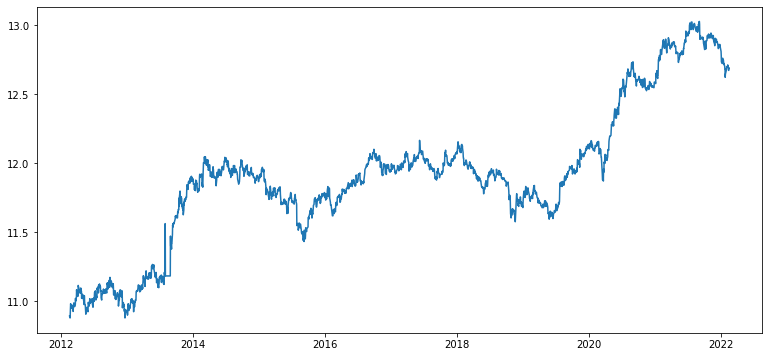

In [42]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log);

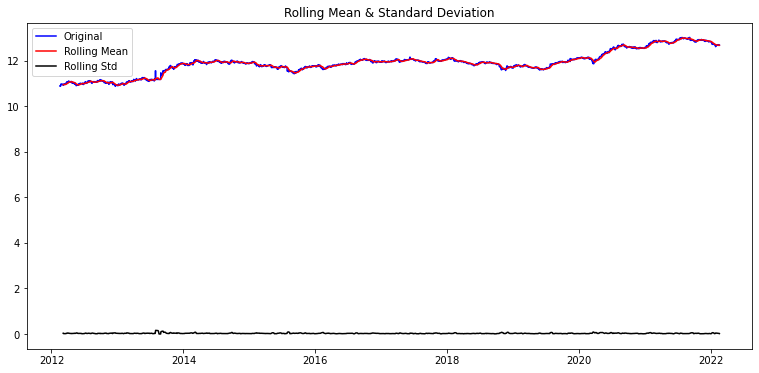

In [43]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [44]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.235316
p-value                           0.658222
#Lags Used                        4.000000
Number of Observations Used    2455.000000
Critical Value (1%)              -3.433016
Critical Value (5%)              -2.862718
Critical Value (10%)             -2.567397
dtype: float64


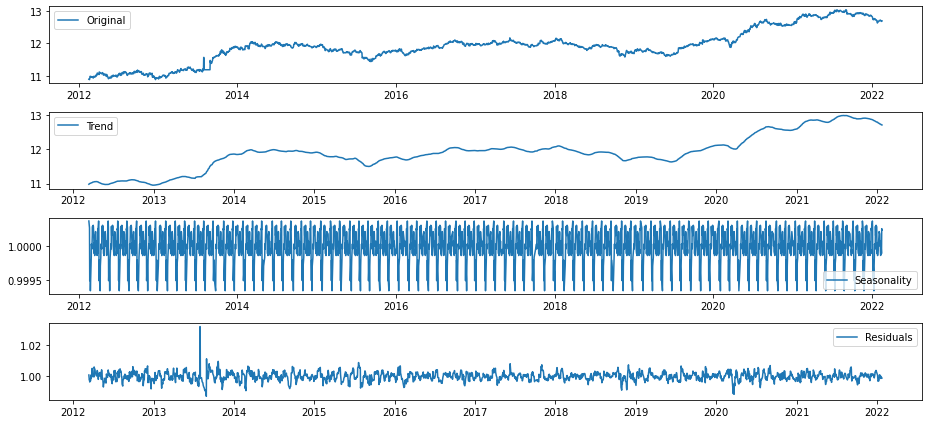

In [45]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

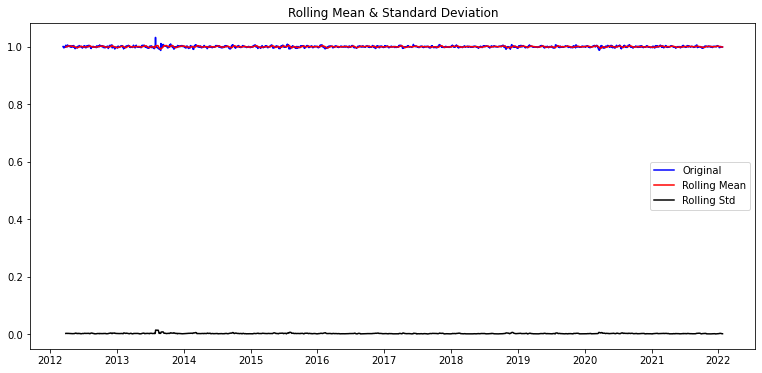

In [46]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [47]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.340597e+01
p-value                        4.469891e-25
#Lags Used                     2.500000e+01
Number of Observations Used    2.404000e+03
Critical Value (1%)           -3.433073e+00
Critical Value (5%)           -2.862743e+00
Critical Value (10%)          -2.567410e+00
dtype: float64


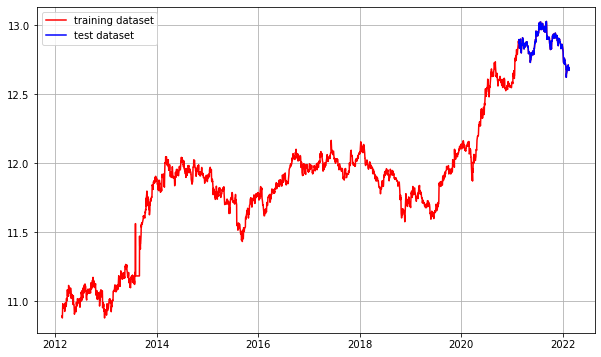

In [48]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

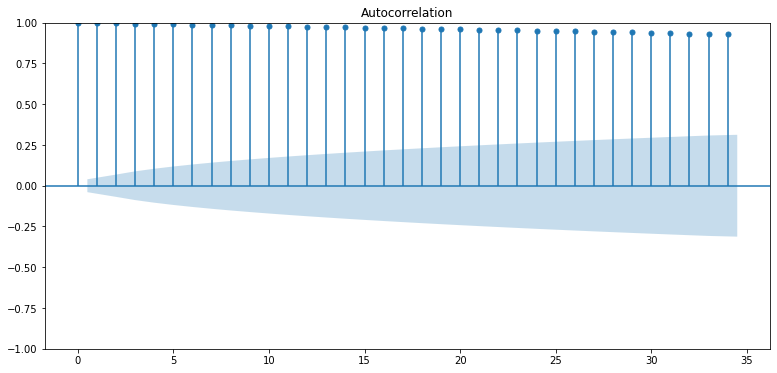

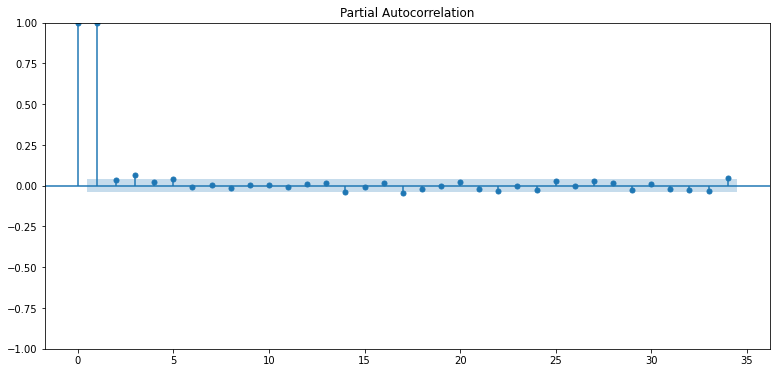

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -28.485362
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2455.000000
Critical Value (1%)              -3.433016
Critical Value (5%)              -2.862718
Critical Value (10%)             -2.567397
dtype: float64


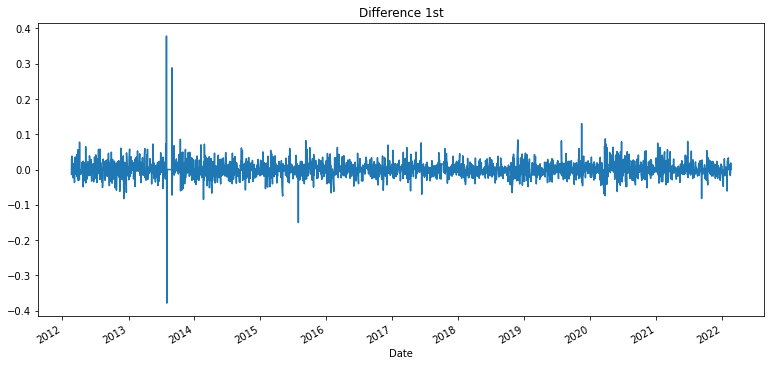

In [50]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.813925e+01
p-value                        2.493496e-30
#Lags Used                     2.300000e+01
Number of Observations Used    2.434000e+03
Critical Value (1%)           -3.433039e+00
Critical Value (5%)           -2.862728e+00
Critical Value (10%)          -2.567403e+00
dtype: float64


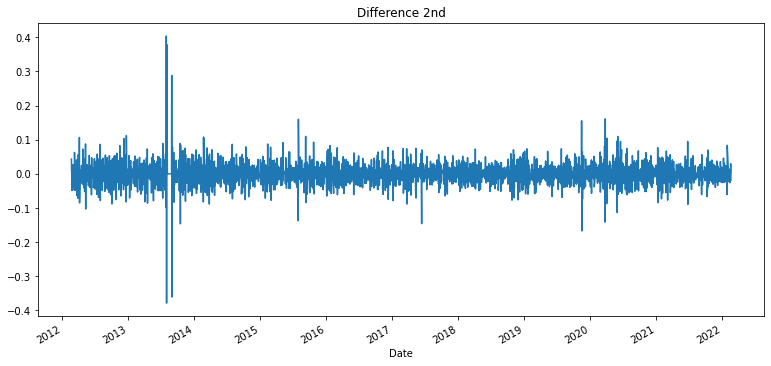

In [51]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [52]:
# 적절한 모수를 찾아주는 라이브러리
from pmdarima import auto_arima
stepwise_fit = auto_arima(ts_log, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11177.680, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11140.988, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11153.366, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11156.584, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11140.904, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11177.490, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11176.298, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-11175.727, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11175.794, Time=3.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11176.278, Time=0.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11175.344, Time=1.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11172.227, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11173.814, Time=1.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-11176.143, Time=0.22 sec

Best

In [53]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2214
Model:                 ARIMA(2, 1, 2)   Log Likelihood                4983.859
Date:                Thu, 17 Feb 2022   AIC                          -9957.717
Time:                        08:55:26   BIC                          -9929.207
Sample:                             0   HQIC                         -9947.302
                               - 2214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1509      0.259     -0.582      0.561      -0.659       0.357
ar.L2          0.3014      0.193      1.563      0.118      -0.077       0.679
ma.L1          0.0555      0.256      0.217      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


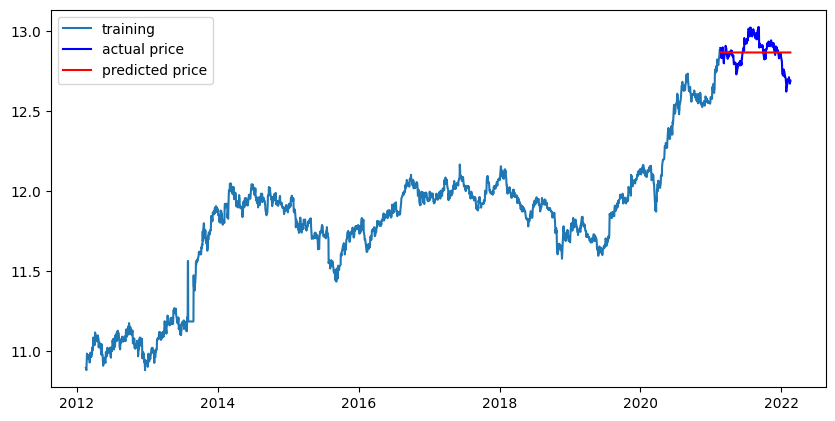

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1090613077.5670295
MAE:  26024.051183946176
RMSE:  33024.43152526671
MAPE: 6.79%


# 애플

In [56]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Ex_11/data/AAPL.csv'  # 애플 10년치
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 하루의 장이 마감하였을 때의 가격 : 종가

ts.head()

Date
2012-02-17    17.932858
2012-02-21    18.387501
2012-02-22    18.322857
2012-02-23    18.442499
2012-02-24    18.657499
Name: Close, dtype: float64

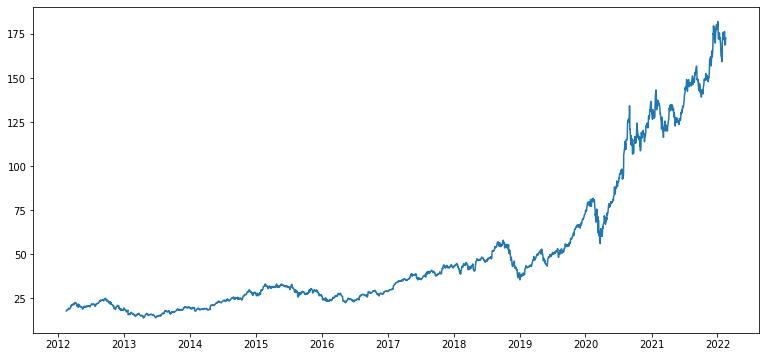

In [57]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts);

In [58]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

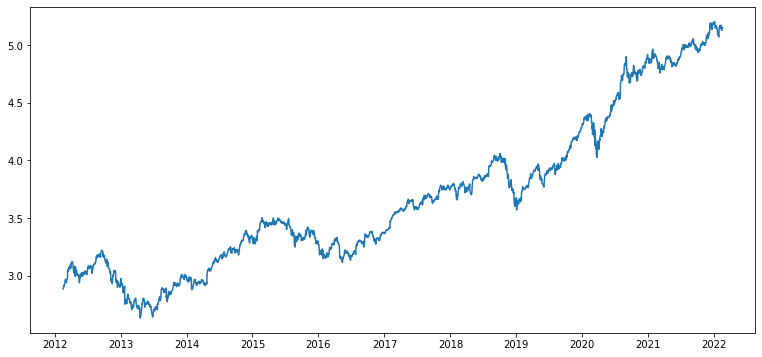

In [59]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log);

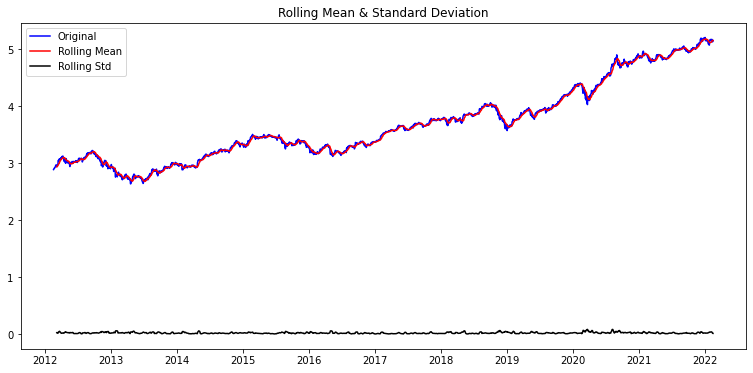

In [60]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [61]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    0.707177
p-value                           0.989980
#Lags Used                       14.000000
Number of Observations Used    2502.000000
Critical Value (1%)              -3.432966
Critical Value (5%)              -2.862696
Critical Value (10%)             -2.567385
dtype: float64


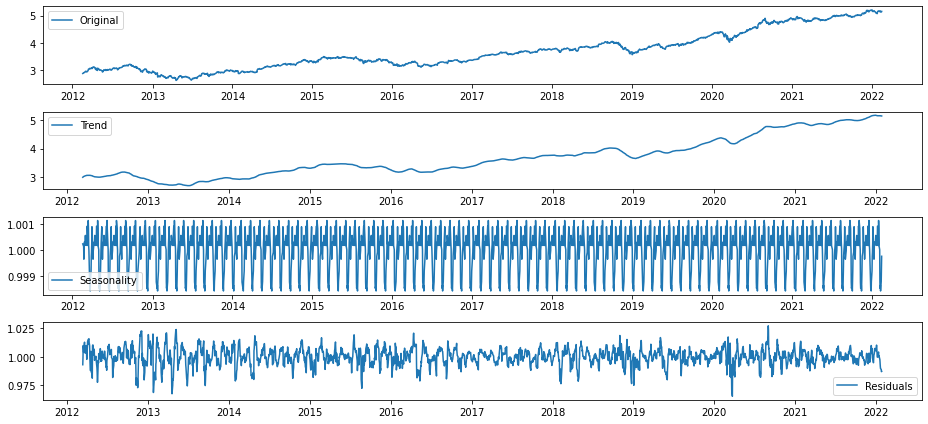

In [62]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

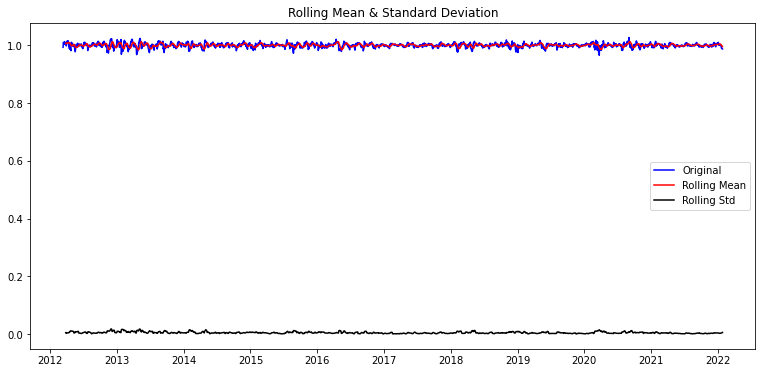

In [63]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [64]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.394892e+01
p-value                        4.741153e-26
#Lags Used                     2.100000e+01
Number of Observations Used    2.465000e+03
Critical Value (1%)           -3.433006e+00
Critical Value (5%)           -2.862713e+00
Critical Value (10%)          -2.567395e+00
dtype: float64


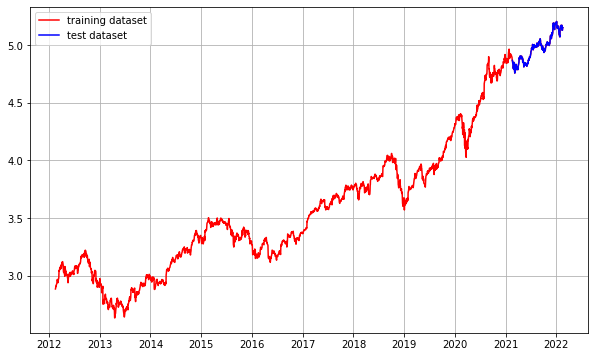

In [65]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

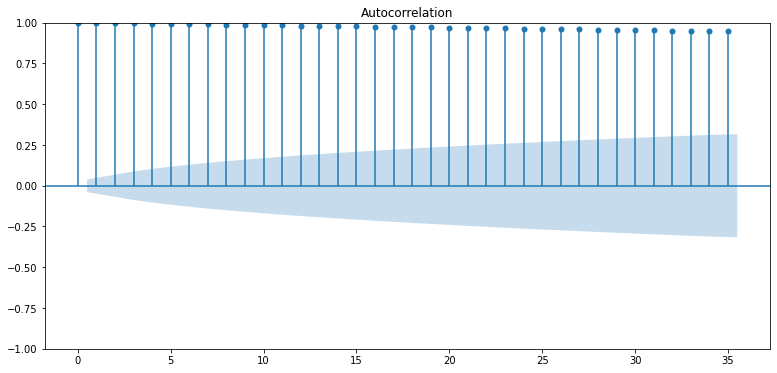

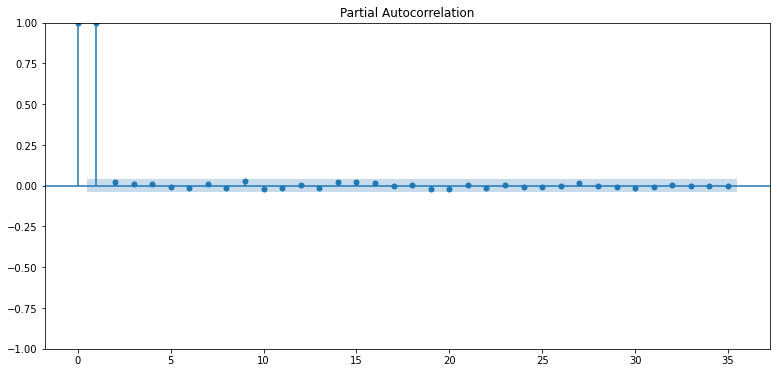

In [66]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.265024e+01
p-value                        1.373424e-23
#Lags Used                     1.300000e+01
Number of Observations Used    2.502000e+03
Critical Value (1%)           -3.432966e+00
Critical Value (5%)           -2.862696e+00
Critical Value (10%)          -2.567385e+00
dtype: float64


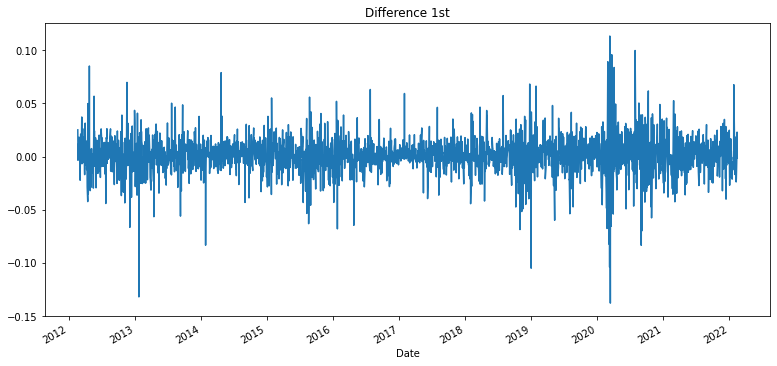

In [67]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.607764e+01
p-value                        5.421406e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.487000e+03
Critical Value (1%)           -3.432982e+00
Critical Value (5%)           -2.862703e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


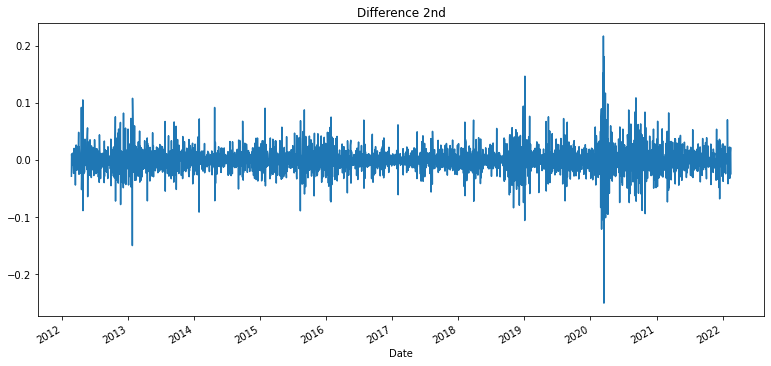

In [68]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [69]:
# 적절한 모수를 찾아주는 라이브러리
from pmdarima import auto_arima
stepwise_fit = auto_arima(ts_log, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13091.072, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13090.260, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13096.654, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13096.679, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13085.932, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13094.670, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13094.679, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13092.689, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13091.557, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.027 seconds


In [70]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2265
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5862.868
Date:                Thu, 17 Feb 2022   AIC                         -11721.737
Time:                        08:57:57   BIC                         -11710.287
Sample:                             0   HQIC                        -11717.559
                               - 2265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0581      0.013     -4.347      0.000      -0.084      -0.032
sigma2         0.0003   5.03e-06     65.595      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


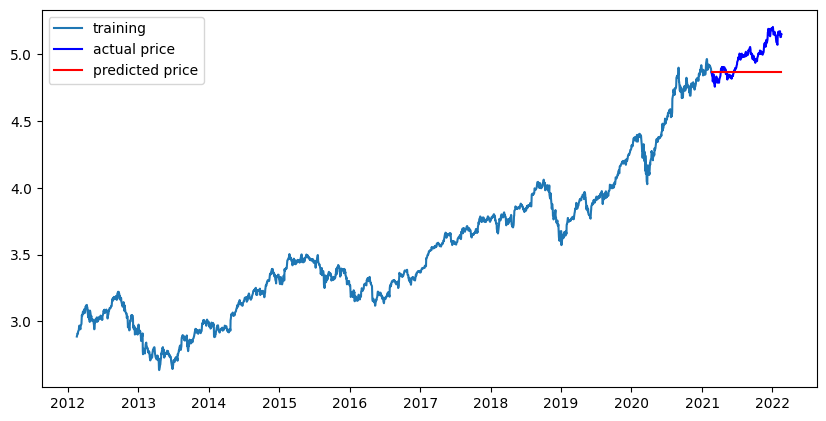

In [71]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  554.5158033179167
MAE:  18.535588621660665
RMSE:  23.54815923417193
MAPE: 11.81%


# 테슬라

In [73]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Ex_11/data/TSLA.csv'  # 테슬라 10년치
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 하루의 장이 마감하였을 때의 가격 : 종가

ts.head()

Date
2012-02-17    6.994
2012-02-21    6.900
2012-02-22    6.844
2012-02-23    6.906
2012-02-24    6.750
Name: Close, dtype: float64

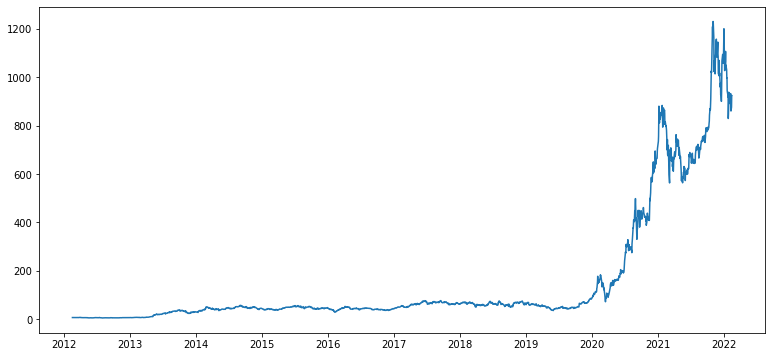

In [74]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts);

In [75]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

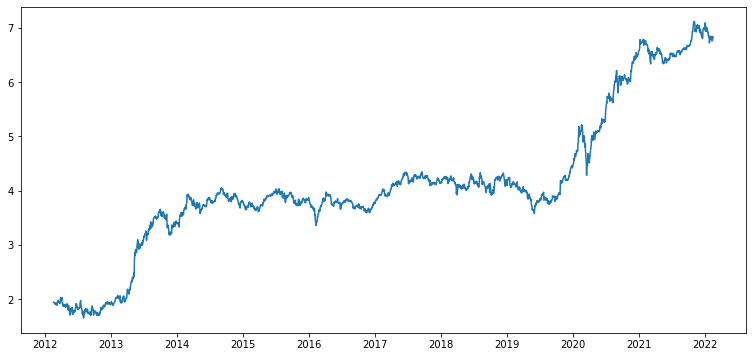

In [76]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log);

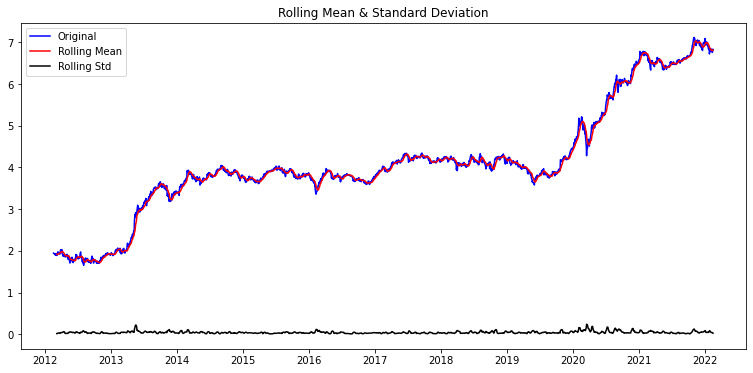

In [77]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [78]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.080470
p-value                           0.951349
#Lags Used                        0.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64


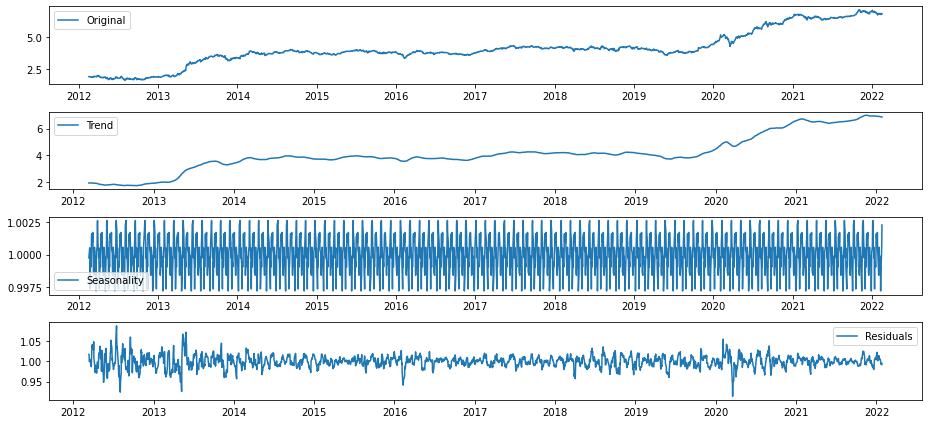

In [79]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

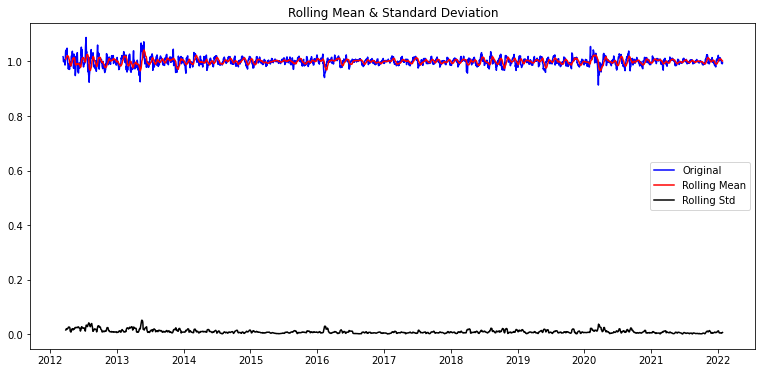

In [80]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [81]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.207982e+01
p-value                        2.245748e-22
#Lags Used                     2.700000e+01
Number of Observations Used    2.459000e+03
Critical Value (1%)           -3.433012e+00
Critical Value (5%)           -2.862716e+00
Critical Value (10%)          -2.567396e+00
dtype: float64


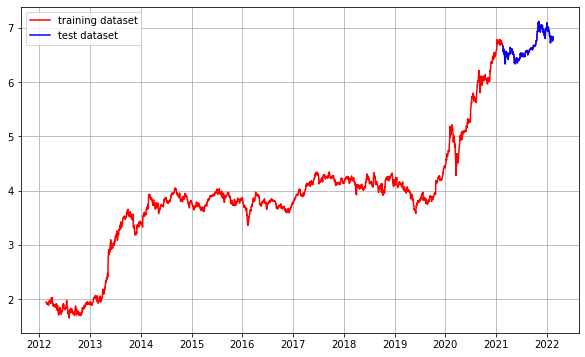

In [82]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

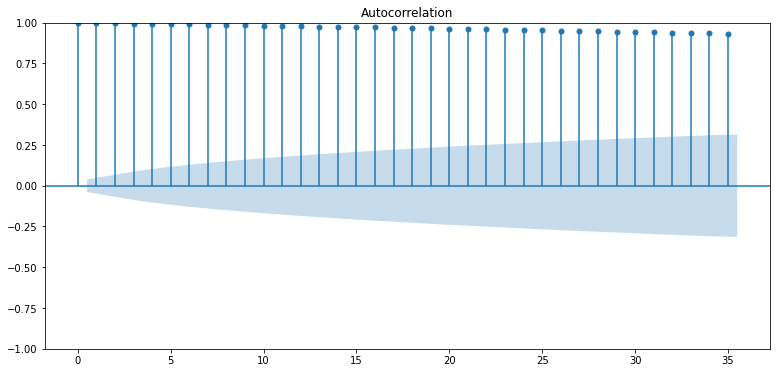

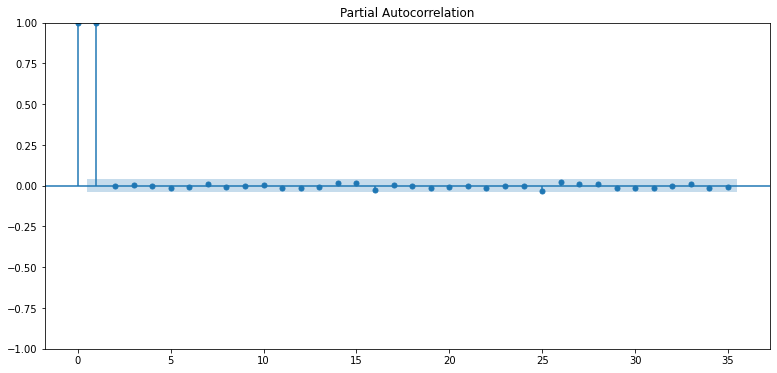

In [83]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -50.323602
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2515.000000
Critical Value (1%)              -3.432953
Critical Value (5%)              -2.862690
Critical Value (10%)             -2.567382
dtype: float64


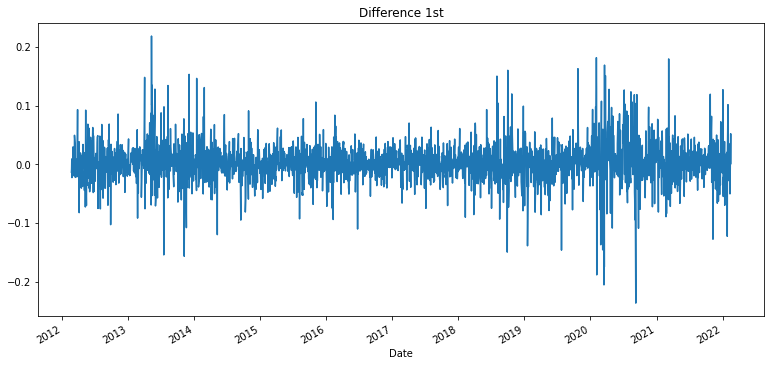

In [84]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.598697e+01
p-value                        6.737140e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.487000e+03
Critical Value (1%)           -3.432982e+00
Critical Value (5%)           -2.862703e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


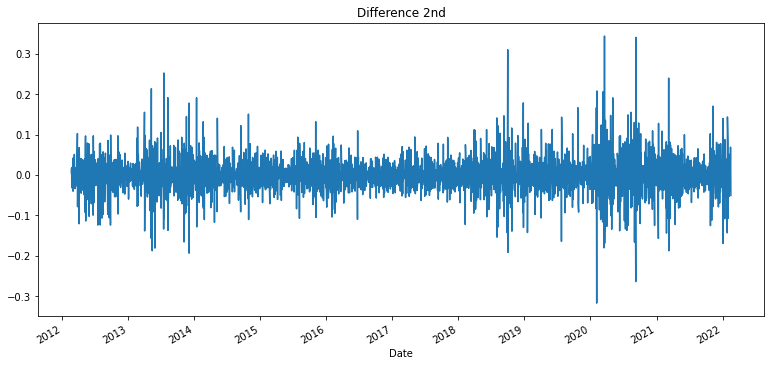

In [85]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [86]:
# 적절한 모수를 찾아주는 라이브러리
from pmdarima import auto_arima
stepwise_fit = auto_arima(ts_log, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9739.657, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9747.588, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9745.625, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9745.624, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9741.795, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9743.625, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.298 seconds


In [87]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2265
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4391.578
Date:                Thu, 17 Feb 2022   AIC                          -8781.157
Time:                        09:00:04   BIC                          -8775.432
Sample:                             0   HQIC                         -8779.068
                               - 2265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   1.81e-05     66.686      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3269.68
Prob(Q):                              0.89   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


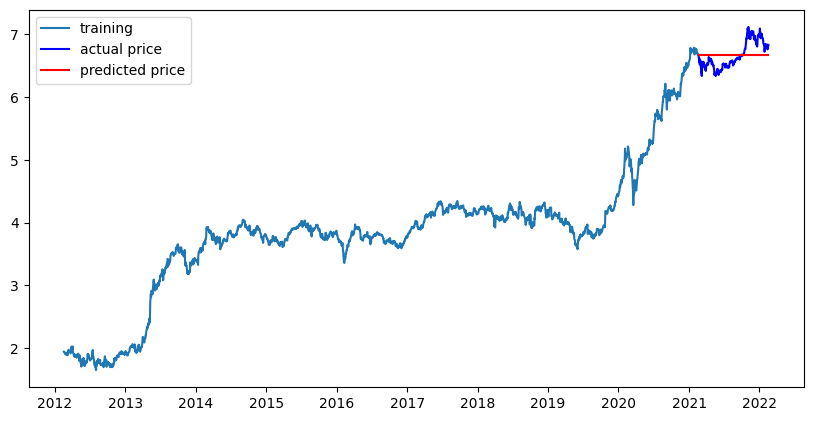

In [88]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30865.40948643672
MAE:  147.5799216984126
RMSE:  175.6855414837451
MAPE: 18.08%


# 회고

- 시계열 ARIMA model을 이용한 주가예측을 해보았다. 뭔가 실생활 데이터를 가지고 해보니 재미는 있었다.
- 하지만 ARIMA model의 이해가 부족해서 모수도 자동으로 추천해주는 라이브러리를 쓰게되고 데이터만 다른 복붙의 형태가 되어버렸다.
- 언젠가 다시 다룬다면 다시 공부를 해서 해봐야겠다.
- prediction 그래프가 일직선인것도 뭔가 찜찜하긴 하다...주어지는대로 좀 하다보니 그런가 나중에 하이퍼파라미터 조정도 해봐야겠다.